In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
# Install necessary packages
!pip install datasets
!pip install torch torchvision

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image
from datasets import load_dataset

In [ ]:
# Create a custom PyTorch Dataset wrapper for the Hugging Face AFHQ dataset
class AFHQDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Each example in the AFHQ dataset has an 'image' field
        image = self.hf_dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image

# Define image transformations: resize to 64x64, center crop, convert to tensor, and normalize.
transform = transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the AFHQ dataset from Hugging Face.
# Note: The "full" configuration is used here. Adjust if needed.
hf_dataset = load_dataset("huggan/AFHQ", "default", split="train")
train_dataset = AFHQDataset(hf_dataset, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
#check dataset size
print(len(train_dataset))

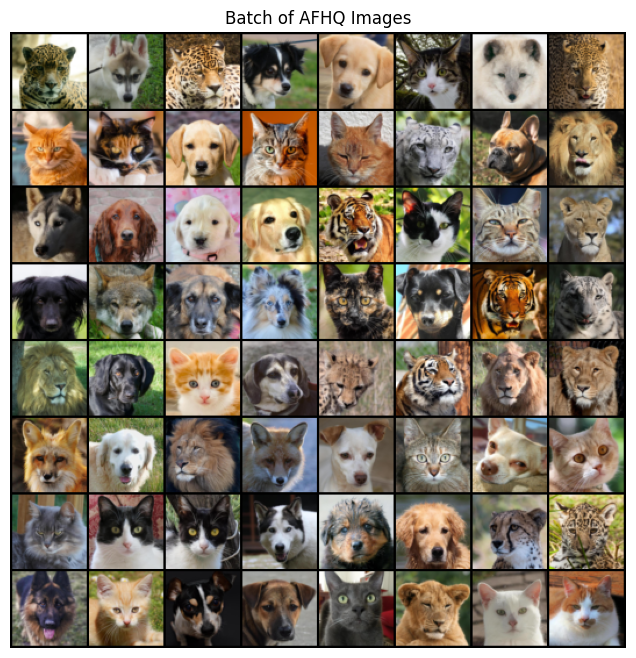

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to denormalize images: reverse the normalization: (x * std + mean)
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

# Grab one batch of images from the dataloader
dataiter = iter(dataloader)
images = next(dataiter)

# Denormalize the images
images_denorm = denormalize(images)

# Create a grid of images
img_grid = torchvision.utils.make_grid(images_denorm, nrow=8)

# Convert the grid from tensor format (C x H x W) to numpy format (H x W x C)
np_img = img_grid.numpy().transpose((1, 2, 0))

# Plot the grid
plt.figure(figsize=(8,8))
plt.imshow(np_img)
plt.title("Batch of AFHQ Images")
plt.axis("off")
plt.show()


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

##Generator model

In [ ]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, feature_maps):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps * 8, feature_maps * 4, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps * 4, feature_maps * 2, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps * 2, feature_maps, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(feature_maps, img_channels, 3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

##Hyperparameters

In [6]:
# Hyperparameters
latent_dim = 128
img_channels = 3
feature_maps = 64
num_epochs = 600
batch_size = 64
lr_G = 0.0001
lr_D = 0.00005
beta1 = 0.5

##Discriminator model and Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import signal
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# Define checkpoint path in Google Drive
checkpoint_path = "/content/drive/MyDrive/GAN-checkpoints/gan_checkpoint.pth"


# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
netG = Generator(latent_dim, img_channels, feature_maps).to(device)
netD = Discriminator(img_channels, feature_maps).to(device)

# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

# Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    print("Checkpoint found! Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch+1}")

# Create output directory for generated images
os.makedirs("output_images", exist_ok=True)

# Function to save model checkpoint
def save_checkpoint(epoch):
    print(f"\nSaving checkpoint at epoch {epoch}...")
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Signal handler to save progress before stopping
def save_and_exit(signum, frame):
    global current_epoch
    save_checkpoint(current_epoch)
    print("Training stopped and checkpoint saved.")
    os._exit(0)

signal.signal(signal.SIGINT, save_and_exit)  # Capture interrupt signal

# Training loop
print("Starting Training Loop...")
for epoch in range(start_epoch, num_epochs):
    current_epoch = epoch  # Keep track of current epoch for saving
    for i, real_images in enumerate(dataloader):
        ############################
        # (1) Update Discriminator
        ############################
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        label_real = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        label_fake = torch.full((b_size,), 0.0, dtype=torch.float, device=device)

        # Forward pass with real images
        output_real = netD(real_images)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()

        # Generate fake images
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach())
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        netG.zero_grad()
        output = netD(fake_images)
        errG = criterion(output, label_real)
        errG.backward()
        optimizerG.step()

        # Print progress
        if i % 50 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {(errD_real + errD_fake).item():.4f} Loss_G: {errG.item():.4f}")

    # Save a batch of generated images after each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
        fake_images = netG(fixed_noise)
        save_image(fake_images, f"output_images/epoch_{epoch+1:03d}.png", normalize=True)

    # Save model checkpoint at the end of each epoch
    save_checkpoint(epoch + 1)


Checkpoint found! Loading checkpoint...
Resuming training from epoch 467
Starting Training Loop...
[467/600][0/253] Loss_D: 1.5814 Loss_G: 7.3037
[467/600][50/253] Loss_D: 0.3891 Loss_G: 4.7262
[467/600][100/253] Loss_D: 0.3881 Loss_G: 4.1505
[467/600][150/253] Loss_D: 0.3789 Loss_G: 3.9899
[467/600][200/253] Loss_D: 0.4021 Loss_G: 3.5641
[467/600][250/253] Loss_D: 0.3987 Loss_G: 4.2459

Saving checkpoint at epoch 467...
Checkpoint saved at /content/drive/MyDrive/GAN-checkpoints/gan_checkpoint.pth
[468/600][0/253] Loss_D: 0.4660 Loss_G: 3.8004
[468/600][50/253] Loss_D: 0.3744 Loss_G: 3.9766
[468/600][100/253] Loss_D: 0.4171 Loss_G: 3.9223
[468/600][150/253] Loss_D: 0.3576 Loss_G: 5.5083
[468/600][200/253] Loss_D: 0.3580 Loss_G: 4.5534
[468/600][250/253] Loss_D: 0.4161 Loss_G: 3.6682

Saving checkpoint at epoch 468...
Checkpoint saved at /content/drive/MyDrive/GAN-checkpoints/gan_checkpoint.pth
[469/600][0/253] Loss_D: 0.4257 Loss_G: 3.7643
[469/600][50/253] Loss_D: 0.3734 Loss_G: 4.220

In [9]:
img_channels = 3
feature_maps = 64
latent_dim = 128
# Load the trained generator
checkpoint_path = "/content/gan_checkpoint_final.pth"

# Initialize the generator model
netG = Generator(latent_dim, img_channels, feature_maps).to(device)

# Load the saved model state dictionary
checkpoint = torch.load(checkpoint_path, map_location=device)
netG.load_state_dict(checkpoint['netG_state_dict'])

# Set model to evaluation mode
netG.eval()

print("Model loaded successfully!")

Model loaded successfully!


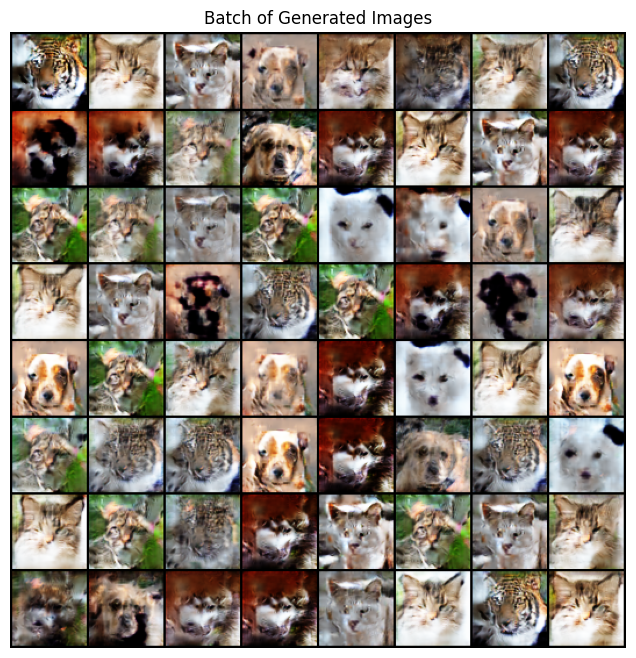

In [36]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # Convert from [-1,1] back to [0,1]

# Generate a batch of images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128  # Ensure this matches your trained model
batch_size = 64  # Same as training batch size

with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    generated_images = netG(noise)

# Apply denormalization
generated_images_denorm = denormalize(generated_images)

# Create a grid of generated images (same format as training images)
img_grid = torchvision.utils.make_grid(generated_images_denorm, nrow=8, padding=2, normalize=True)

# Convert the grid from tensor format (C, H, W) to NumPy format (H, W, C)
np_img = img_grid.cpu().numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)

# Display the generated batch
plt.figure(figsize=(8, 8))  # Match training batch display size
plt.imshow(np.clip(np_img, 0, 1))  # Ensure valid pixel range
plt.title("Batch of Generated Images")
plt.axis("off")
plt.show()
